In [3]:
import gym
import gym_chrome_dino
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
import cv2
import random
from gym_chrome_dino.utils.wrappers import make_dino

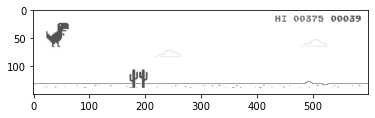

In [96]:
plt.imshow(screen)

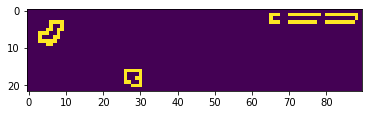

In [97]:
screen = cv2.resize(screen,(0,0),fx = 0.15,fy = 0.15, interpolation = cv2.INTER_AREA)
screen = cv2.Canny(screen,100,200)/255
plt.imshow(screen)

In [8]:
def imgpreprocessing(x):
    screen = np.array(x)
    screen = cv2.resize(screen,(0,0),fx = 0.3,fy = 0.3, interpolation = cv2.INTER_AREA)
    screen = cv2.Canny(screen,100,200)/255
    screen = screen.reshape(1,24,48,1)
    return screen

In [9]:
model = keras.models.Sequential()

model.add(Conv2D(32,(2,2),strides=(2,2),padding='same',activation = 'relu'))
model.add(Conv2D(64,(4,4),strides=(2,2),padding= 'same',activation = 'relu'))
model.add(Conv2D(64,(3,3),strides=(1,1),padding= 'same',activation = 'relu'))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(16,activation = 'relu'))
model.add(Dense(3))

In [10]:
model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics =['accuracy'])

In [ ]:
env  = gym.make('ChromeDino-v0')

In [ ]:
done = 0
discount = 0.9

max_episodes = 1000

state_list = list()
q_list = list()

score_list = list()

replay_mem = list()

replay_size = 32
rr = 10
replay_limit = 2048

isrand = 0

e = 0

env = make_dino(env, timer = True, frame_stack = True)
done =True
for episode in range(max_episodes):
    print(episode,e)
    state_list = list()
    q_list = list()
    screen = env.reset()
    state = imgpreprocessing(screen)
    done = 0
    while not done:
        e = 1 / ((episode / 7) + 1)
        q = model.predict(state)
        
        if np.random.rand(1)<e:
            action = env.action_space.sample()
            isrand = 1
        else:
            action = np.argmax(q)
            isrand = 0
            
        print(q,np.argmax(q),isrand,action)
        
        screen_next,reward,done,_ = env.step(action)
        state_next = imgpreprocessing(screen_next)
        
        if done:
            reward = -10
            score_list.append(env.unwrapped.game.get_score())
        else:
            reward = 1
        replay_mem.append([state,state_next,action,reward,done])
        if len(replay_mem)>replay_limit:
            del replay_mem[0]
        
        state_list = list()
        q_list = list()
        
        if len(replay_mem)< rr:
            replay_size = len(replay_mem)
        else:
            replay_size = rr
        for sample in random.sample(replay_mem,replay_size):
            state, state_next, action, reward, done = sample
            if done:
                q[0,action] == reward
            else:
                q_next = model.predict(state_next)
                q[0,action] == reward + discount*np.max(q_next)
            state_a = state.reshape(24,48,1)
            state_list.append(state_a)
            q_a = q.reshape(3)
            q_list.append(q_a)
        state_list = np.array(state_list)
        q_list = np.array(q_list)
        hist = model.fit(state_list,q_list,epochs = 30, verbose =0)
        state = state_next

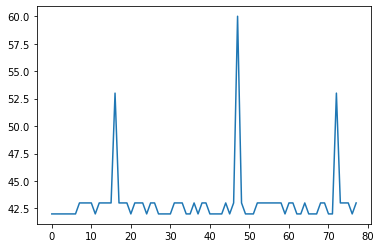

In [17]:
plt.plot(np.arange(len(score_list)),score_list)